In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from scipy.stats import rv_continuous

0.2
s = 0.2, E_o = 26
Generating Batch
Generating Batch
Generating Batch
Generating Batch
Generating Batch
Generating Batch
Generating Batch
0.6
s = 0.6, E_o = 31.4268
Generating Batch
Generating Batch
Generating Batch
Generating Batch
Generating Batch
Generating Batch
Generating Batch
Generating Batch
Generating Batch
Generating Batch
Generating Batch
Generating Batch
Generating Batch
1.2
s = 1.2, E_o = 42.8508
Generating Batch
Generating Batch
Generating Batch
Generating Batch
Generating Batch
Generating Batch
Generating Batch
Generating Batch
Generating Batch
Generating Batch
Generating Batch
Generating Batch
Generating Batch
Generating Batch
Generating Batch
Generating Batch
Generating Batch
Generating Batch
Generating Batch
Generating Batch


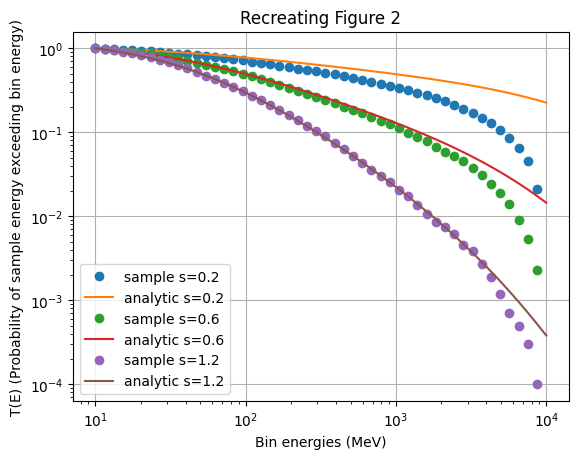

In [14]:
# Goals of this
# Calculate a linspace of energy densities and their corresponding energies

def T_func(E, E_0, s):
    """
    Analytic Integral function (cumulative distribution (cdf)) T(E; s) from the paper
    Says how many particles have energies ABOVE E

    E is energy in MeV that you evaluate the function
    s is shower age
    E_0 is characteristic energy
    """
    return (((0.89*E_0 - 1.2) / (E_0 + E)) ** s) * ((1 + ((10**(-4)) * s * E))**(-2))

def sample_from_distribution_vectorized(s, E_min, E_max, N_samples, E_0, batch_size=100000, plot = False):
    """
    Generates random energies from the differential distribution n(E) = -dT/dE
    using a vectorized acceptance-rejection method.

    s = shower age
    E_min = minimum energy of the particle
    #_max = maximum energy of the particle
    N_samples = Total amount of random energies that this will return
    E_0 = characteristic energy?
    batch_size = how large the random arrays are each time
    """
    # Create array of energies to compute T(E) and its derivative
    E_linspace = np.linspace(E_min, E_max, 1000)
    T_linspace = T_func(E_linspace, E_0, s)

    # Step size (used for numerical differentiation)
    dE = E_linspace[1] - E_linspace[0]

    # Numerically differentiate T(E) with respect to E
    dT_dE = np.gradient(T_linspace, dE)

    if plot == True:
        plt.plot(dT_dE)
        plt.title("Plot of linspace")
        plt.show()
        print(len(dT_dE))

    # Since T(E) decreases as E increases, dT/dE is negative
    # n(E) = -dT/dE is the positive density of particles at energy E. Needs to be calculated for each s as s affects T( E )
    n_linspace = -dT_dE 

    if plot == True:
        plt.plot(n_linspace)
        plt.title("Plot of linspace")
        plt.show()

    # n_linspace has all the particle density values at different energies
    # n_max is basically the absolute max density, not the energies themselves
    n_max = np.max(n_linspace)
    accepted_samples = []

    # Runs continously until the total number of accepted samples in the list reaches the requested number of samples
    while len(accepted_samples) < N_samples:
        print("Generating Batch")
        # Generate an array of possible energies (between E_min and E_max)
        E_candidates = np.random.uniform(E_min, E_max, batch_size)
        
        # Generates an array that can cover the full range of density values, act as random thresholds to compare against interpolated density n(E)
        y_candidates = np.random.uniform(0, n_max, batch_size)
        
        # Uses linear interpolation to estimate the value of the differential distribution n(E) at each E_candidate 
        n_candidates = np.interp(E_candidates, E_linspace, n_linspace) # np.interp works by giving it desired x values, true x values and true y valyes to get desired y values
        
        # When the density of the energy candidates is higher than the generated threshold density, it is accepted
        # More energies will be accepted when the max density is lower
        accepted = E_candidates[y_candidates < n_candidates]
        accepted_samples.extend(accepted.tolist())

        # Energies where n(E) is higher are more likely to be accepted

    # Return exactly N_samples samples
    return np.array(accepted_samples[:N_samples])

# Parameters
E_o = 80 #MeV
E_min = 10 #MeV
E_max = 10000 #MeV
s_values = [0.2, 0.6, 1.2]
N_samples = 10000

#Loop for each time
for s in s_values:
    print(s)

    #Calculating E_o the same way as the paper
    if s >= 0.4:
        E_o = 44-17*(s-1.46)**2
    else:
        E_o = 26
    print(f"s = {s}, E_o = {E_o}")

    # Gets an array of energies that approximately give a density that is high enough compared to a random threshold for that time
    # This means the final sample array of energies is distributed according to n(E)
    samples = sample_from_distribution_vectorized(s, E_min, E_max, N_samples, E_o)

    # We define log bins here
    # For each log bin (which is an energy threshold) we next count how many sampled energies exceed it
    E_bins = np.logspace(np.log10(E_min), np.log10(E_max))

    # T_sample is an array that holds counts for how many sample energies have energies greater than the bin thresholds
    T_sample = np.array([np.sum(samples > E_cut) for E_cut in E_bins])

    # This should generate the theoretical cumulative distribution based on the original function
    # If the simulation is correct, the T_sample should match the T_analytic closely
    T_analytic = T_func(E_bins, E_o, s)

    # Determine norm factors
    T_sample_norm_factor = T_sample[0] # Count at E_min
    T_analytic_norm_factor = T_analytic[0] # Count at E_min

    # This should normalize the analytic curve so the value at E_min better matches the simulations value
    T_sample_norm = T_sample/T_sample_norm_factor
    T_analytic_norm = T_analytic/T_analytic_norm_factor

    # This plots the simulated points with dots, and the theoretical curve using dashes
    plt.loglog(E_bins, T_sample_norm, 'o', label = f"sample s={s}")
    plt.loglog(E_bins, T_analytic_norm, '-', label = f"analytic s={s}")

plt.xlabel('Bin energies (MeV)')
plt.ylabel('T(E) (Probability of sample energy exceeding bin energy)')
plt.title('Recreating Figure 2')
# plt.ylim([1e-1, 1e0])
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# On the left, almost all 1000 energy samples exceed 1MeV
# At higher energies, only about 100 samples have energies above 100MeV
# Each sample corresponds to 1 particle carrying energy randomly drawn from the random distribution
# Therefore this plot is the total spectrum of energies after different amounts of time

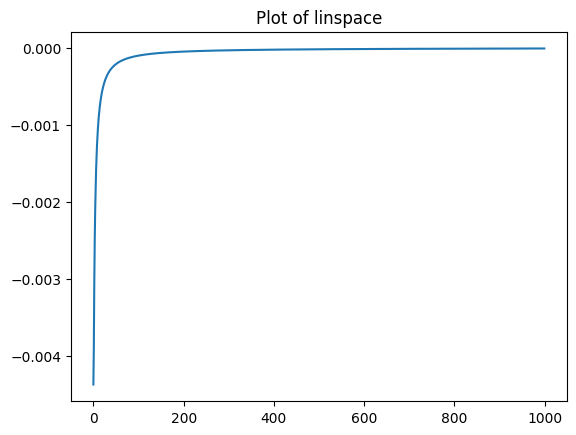

1000


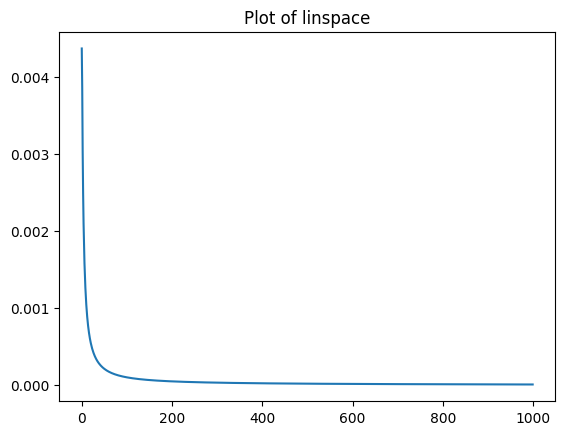

Generating Batch
Generating Batch
Generating Batch
Generating Batch
Generating Batch
Generating Batch
Generating Batch


In [16]:
samples = sample_from_distribution_vectorized(0.2, E_min, E_max, N_samples, 26, plot = True)